In [1]:
# Importing necessary libraries
from pycaret.datasets import get_data
from pycaret.regression import *
import seaborn as sns
import ast
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [2]:
# Loading all of the necessary DataFrames
df_fi_g = get_data('outputs/general/feature_importance_general')
df_fi_i = get_data('outputs/individual/feature_importance_individual')
df_t_g = get_data('outputs/general/test_general')
df_t_i = get_data('outputs/individual/test_individual')
# Removing 'Least Angle Regression' from the data since results are so bad it makes the rest of the data useless (severe outlier)
df_t_g = df_t_g[df_t_g['Model'] != 'Least Angle Regression']
df_t_i = df_t_i[df_t_i['Model'] != 'Least Angle Regression']
df_fi_g.groupby(['Model', 'Feature']).median().reset_index().sort_values('Value', axis=0, ascending=False)

,Feature,Value,Model,Training Subjects
0,error,0.000000,KNeighborsRegressor(n_jobs=-1),"(1, 2, 3)"
1,wrist_acc_time,0.373767,"RandomForestRegressor(n_jobs=-1, random_state=...","(1, 2, 3)"
2,upperarm_acc_mean,0.048827,"RandomForestRegressor(n_jobs=-1, random_state=...","(1, 2, 3)"
3,upperarm_acc_med,0.039263,"RandomForestRegressor(n_jobs=-1, random_state=...","(1, 2, 3)"
4,trunk_acc_rms,0.031911,"RandomForestRegressor(n_jobs=-1, random_state=...","(1, 2, 3)"


,Feature,Value,Model,Subject
0,error,0.000000,KNeighborsRegressor(n_jobs=-1),1
1,wrist_acc_time,0.499202,DecisionTreeRegressor(random_state=7337),1
2,trunk_acc_med,0.355585,DecisionTreeRegressor(random_state=7337),1
3,wrist_acc_std,0.034872,DecisionTreeRegressor(random_state=7337),1
4,wrist_acc_mean,0.031881,DecisionTreeRegressor(random_state=7337),1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Training Subjects
0,K Neighbors Regressor,0.2900,0.2832,0.5322,0.9491,0.1965,0.1167,"(1, 2, 3)"
1,Random Forest Regressor,0.7996,1.3885,1.1783,0.7504,0.4134,0.2486,"(1, 2, 3)"
2,Decision Tree Regressor,0.7978,2.3997,1.5491,0.5686,0.5187,0.2786,"(1, 2, 3)"
3,Light Gradient Boosting Machine,0.9219,1.6342,1.2783,0.7062,0.4405,0.3217,"(1, 2, 3)"
4,Extra Trees Regressor,0.9356,1.6844,1.2979,0.6972,0.4452,0.3114,"(1, 2, 3)"


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Subject
0,K Neighbors Regressor,0.1088,0.0641,0.2532,0.9339,0.1277,0.1227,1
1,Decision Tree Regressor,0.1471,0.1471,0.3835,0.8483,0.1922,0.1705,1
2,Gradient Boosting Regressor,0.2442,0.1528,0.3909,0.8424,0.2041,0.1856,1
3,Extra Trees Regressor,0.2788,0.1649,0.4061,0.8300,0.2305,0.2114,1
4,Random Forest Regressor,0.3303,0.2036,0.4512,0.7901,0.2515,0.1978,1


,Model,Feature,Value
143463,Lars(random_state=8033),upperarm_acc_std,inf
143482,Lars(random_state=8033),wrist_acc_rms,inf
143453,Lars(random_state=8033),trunk_jerk_rms,inf
143454,Lars(random_state=8033),trunk_jerk_std,inf
143457,Lars(random_state=8033),upperarm_acc_mean,inf
...,...,...,...
166255,Lasso(random_state=8746),upperarm_acc_perc75,0.0
166254,Lasso(random_state=8746),upperarm_acc_perc25,0.0
166253,Lasso(random_state=8746),upperarm_acc_min,0.0
0,AdaBoostRegressor(random_state=1048),pace,0.0


## Subject influence on MAE?

In [3]:
# For each model, gets the models with the biggest/smallest 3 (?) MAE values
df_t_g_max = df_t_g.groupby('Model').apply(lambda x: x.nlargest(3, 'MAE')).drop('Model', axis=1).reset_index().drop('level_1', axis=1)
df_t_g_min = df_t_g.groupby('Model').apply(lambda x: x.nsmallest(3, 'MAE')).drop('Model', axis=1).reset_index().drop('level_1', axis=1)

In [4]:
count = {}

# Gets the list of training subjects from either 'df_t_g_max' or 'df_t_g_min' 
for test_set in df_t_g_max['Training Subjects'].tolist():  # CHANGE df_t_g_max/df_t_g_max
    test_set = ast.literal_eval(test_set)  # Converts training subjects value to tuple from string
    
    # Stores the count of subjects in dict (key = subject, val = count)
    for subject in test_set:
        if subject not in count:
            count[int(subject)] = 0
        count[int(subject)] += 1

# Gets the total number of models in DataFrame
total = len(df_t_g_max['Training Subjects'].tolist())
appearances = {}

# Gets percentage that subject appears out of total, stores in dict
for subj, app in count.items():
    appearances[f"Subject {subj}"] = round((app / total) * 100, 2)
appearances

{'Subject 1': 60.78,
 'Subject 12': 35.29,
 'Subject 17': 58.82,
 'Subject 8': 19.61,
 'Subject 10': 58.82,
 'Subject 4': 21.57,
 'Subject 5': 31.37,
 'Subject 2': 3.92,
 'Subject 16': 3.92,
 'Subject 15': 1.96,
 'Subject 9': 1.96,
 'Subject 13': 1.96}

## Most Important Features

### Done two ways: 

#### Grouping all occurences of each model under one group, regardless of test subjects used

This method is kind of convoluted and it's difficult to understand the results, so it might be best to just ignore this one.

In [5]:
# There are 58 features per model, and there are 364 different variations of each model.
# So each feature can have 364 different values depending on which subject set the model was run using.
# 58 * 364 = 21112. We could get the top features from between 1 - 21112. 
# Since the best feature is almost always wrist_mean_acc, we have to select a high number of top features from each model to get anythin other than wrist_acc_time
NUM_FEATURES = 364*2  # 364 different models, so I feel like its fair to get the top 364 
ref_models = ['RandomForestRegressor', 'DecisionTreeRegressor', 'LGBMRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor']

df_fi_g_s1 = df_fi_g
df_fi_g_s1['Model'] = df_fi_g_s1['Model'].str.split('(').str[0]
df_fi_g_s1 = df_fi_g_s1.drop(index=df_fi_g_s1[df_fi_g_s1['Feature'] == 'error'].index)
df_fi_g_sub = df_fi_g_s1[df_fi_g_s1['Model'].isin(ref_models)]
largest_values = df_fi_g_sub.groupby('Model')['Value'].nlargest(NUM_FEATURES)
max_features = df_fi_g_sub.loc[largest_values.index.get_level_values(1)].reset_index().drop('index', axis=1)
max_features['Feature'].value_counts(normalize=True) * 100

wrist_acc_time          50.000000
upperarm_acc_perc25     10.741758
trunk_acc_rms            6.126374
trunk_acc_mean           4.780220
weight                   4.120879
wrist_jerk_perc25        3.434066
upperarm_acc_mean        2.967033
wrist_acc_med            2.445055
trunk_jerk_mad           2.115385
wrist_jerk_max           1.428571
trunk_acc_perc75         1.373626
trunk_acc_med            1.346154
upperarm_acc_min         1.071429
upperarm_acc_med         0.934066
trunk_acc_max            0.879121
wrist_acc_perc25         0.714286
wrist_acc_mean           0.576923
trunk_jerk_std           0.549451
trunk_acc_perc25         0.494505
wrist_acc_std            0.467033
trunk_acc_std            0.467033
trunk_jerk_min           0.384615
trunk_acc_min            0.357143
upperarm_jerk_perc25     0.247253
wrist_jerk_rms           0.247253
wrist_jerk_mean          0.219780
wrist_jerk_std           0.219780
trunk_acc_mad            0.192308
wrist_acc_min            0.192308
upperarm_acc_r

#### Treating each model as separate (taking into account the test subject)

In [6]:
# Here I am separating models by their test subjects

# Basically, top 5 features showing up for each variation of model
# The most that one feature can show up is 58 
NUM_FEATURES = 5

largest_values = df_fi_g.groupby('Model')['Value'].nlargest(NUM_FEATURES)  # Gets the largest values for feature importance
max_features = df_fi_g.loc[largest_values.index.get_level_values(1)].reset_index().drop('index', axis=1)
max_features['Feature'].value_counts(normalize=True) * 100

wrist_acc_time          38.888889
trunk_jerk_max          21.111111
error                   11.111111
wrist_acc_length         5.555556
upperarm_acc_perc75      4.444444
trunk_acc_rms            4.444444
trunk_acc_mean           3.333333
wrist_acc_mean           2.222222
trunk_jerk_perc25        2.222222
wrist_acc_med            1.111111
upperarm_acc_std         1.111111
trunk_acc_std            1.111111
trunk_acc_perc25         1.111111
upperarm_jerk_perc75     1.111111
trunk_acc_max            1.111111
Name: Feature, dtype: float64

### Individual

In [7]:
# Same as the general version but for individual models...
NUM_FEATURES = 5

# Gets the n largest number of features per model
largest_values = df_fi_i.groupby('Model')['Value'].nlargest(NUM_FEATURES)

# ...
max_features = df_fi_i.loc[largest_values.index.get_level_values(1)].reset_index().drop('index', axis=1)
max_features['Feature'].value_counts(normalize=True) * 100

wrist_acc_time          15.402299
wrist_acc_length         6.781609
wrist_jerk_max           5.402299
upperarm_jerk_max        4.712644
trunk_acc_mean           3.218391
wrist_jerk_med           2.873563
upperarm_acc_mean        2.758621
trunk_acc_rms            2.758621
upperarm_jerk_perc25     2.528736
trunk_jerk_max           2.413793
trunk_jerk_std           2.413793
upperarm_acc_max         2.298851
upperarm_acc_min         2.183908
upperarm_acc_med         1.839080
upperarm_acc_perc25      1.839080
upperarm_acc_rms         1.724138
pace                     1.724138
trunk_acc_perc75         1.609195
trunk_jerk_mad           1.609195
trunk_acc_med            1.494253
wrist_acc_med            1.494253
upperarm_jerk_perc75     1.379310
upperarm_jerk_med        1.379310
trunk_acc_max            1.379310
wrist_jerk_perc75        1.379310
upperarm_jerk_mad        1.379310
trunk_acc_std            1.379310
wrist_acc_max            1.264368
wrist_jerk_mad           1.264368
wrist_acc_perc

# Graphs (All), General

## Box Plot

Text(0.5, 1.0, 'TITLE')

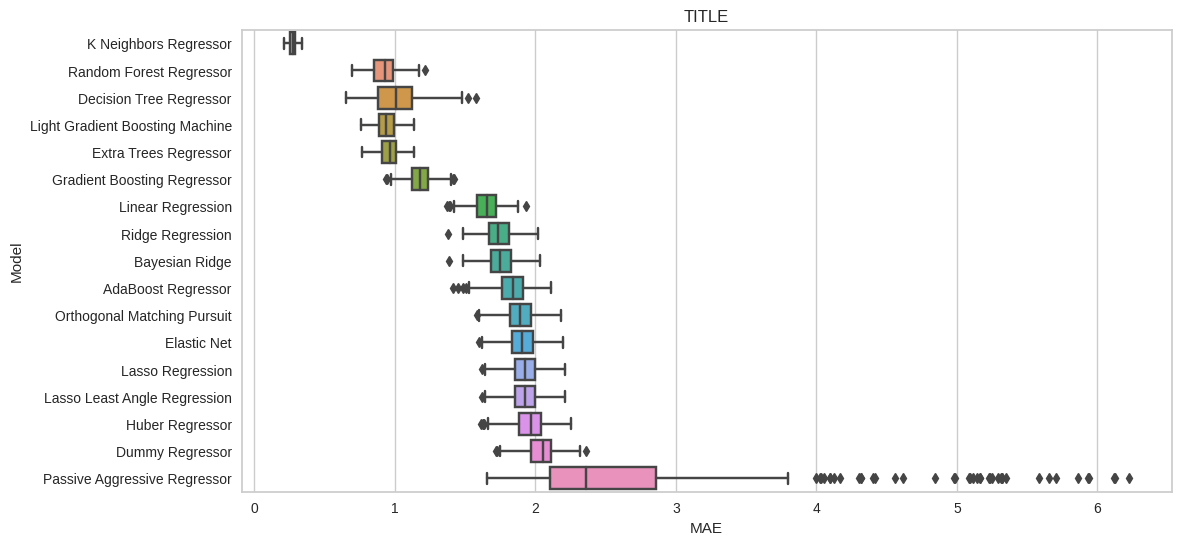

In [8]:
# TODO: Add Title To Graphs (explains what is going on)
# Convert graphs to mp4 slideshow (save figures in folder...)

g = sns.boxplot(x='MAE', y='Model', data=df_t_g)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 6)

# Add title
plt.title('TITLE')

## Scatter Plot

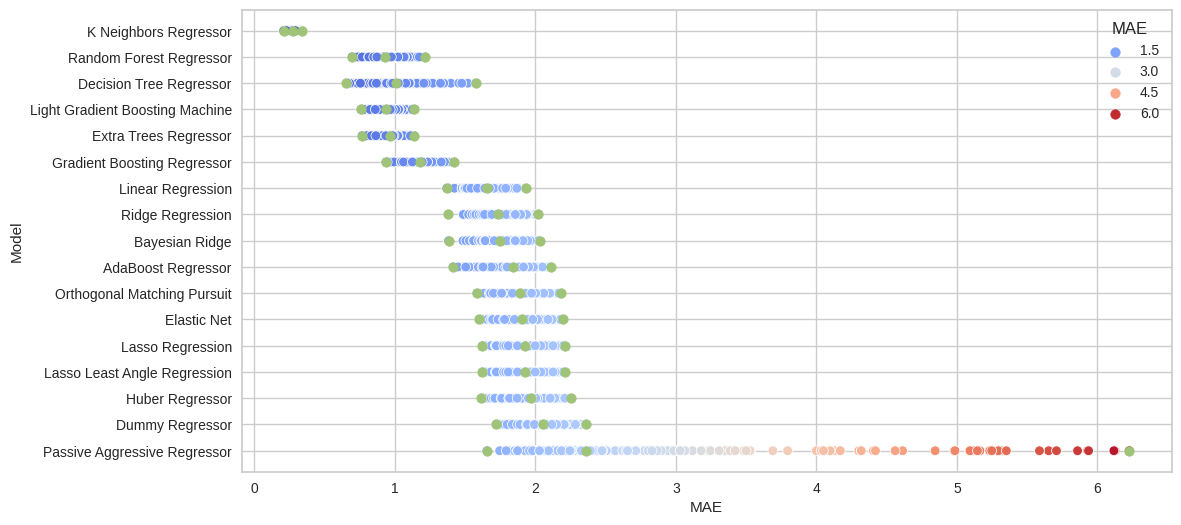

In [9]:
g = sns.scatterplot(data=df_t_g, x='MAE', y='Model', hue='MAE', palette='coolwarm')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 6)

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Filter the quantiles for each sensor
quantiles = df_t_g.groupby('Model')['MAE'].quantile(quantile_set).reset_index()

# Plot the quantiles as points on the scatterplot
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='o')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='o')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='o')

## Violin Plot

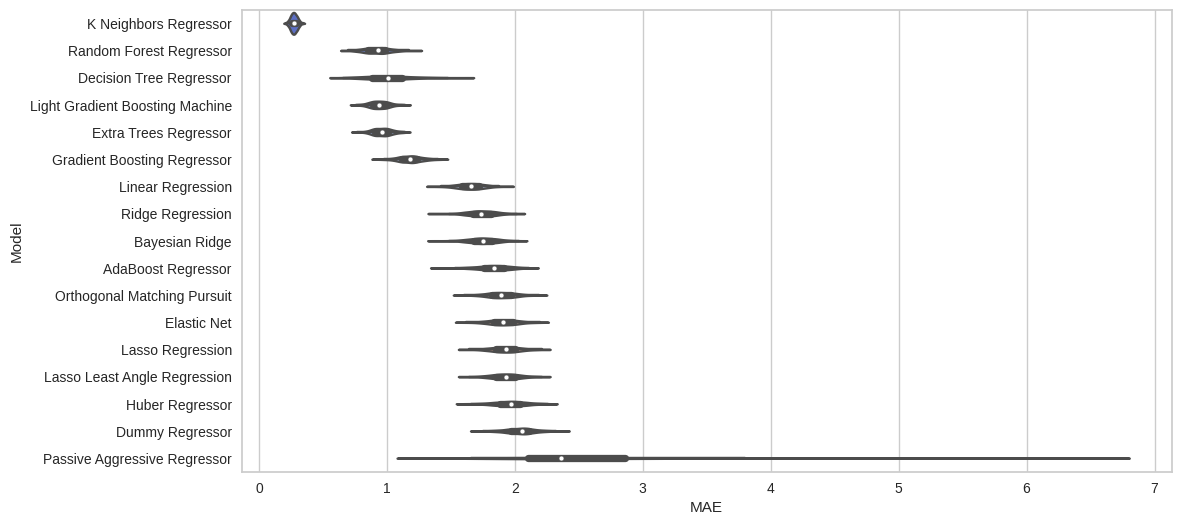

In [10]:
fig, ax = plt.subplots()
g = sns.violinplot(x='MAE', y='Model', data=df_t_g, ax=ax, palette='coolwarm', split=True)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 6)

# Graphs (Sensors), General

In [11]:
df_t_g_s = get_data('outputs/general/sensor_test_general')
df_t_g_s = df_t_g_s[df_t_g_s['Model'] != 'Least Angle Regression']

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Training Subjects,Sensor,Combinations
0,K Neighbors Regressor,0.2955,0.3316,0.5759,0.9474,0.1986,0.1079,"(1,)",wrist,1
1,Decision Tree Regressor,0.6382,1.8229,1.3502,0.7109,0.4595,0.2382,"(1,)",wrist,1
2,Random Forest Regressor,0.7601,1.2916,1.1365,0.7951,0.3908,0.2319,"(1,)",wrist,1
3,Light Gradient Boosting Machine,0.9341,1.6694,1.2921,0.7352,0.4390,0.2954,"(1,)",wrist,1
4,Extra Trees Regressor,1.0709,2.2395,1.4965,0.6448,0.4726,0.3205,"(1,)",wrist,1


## Box Plot

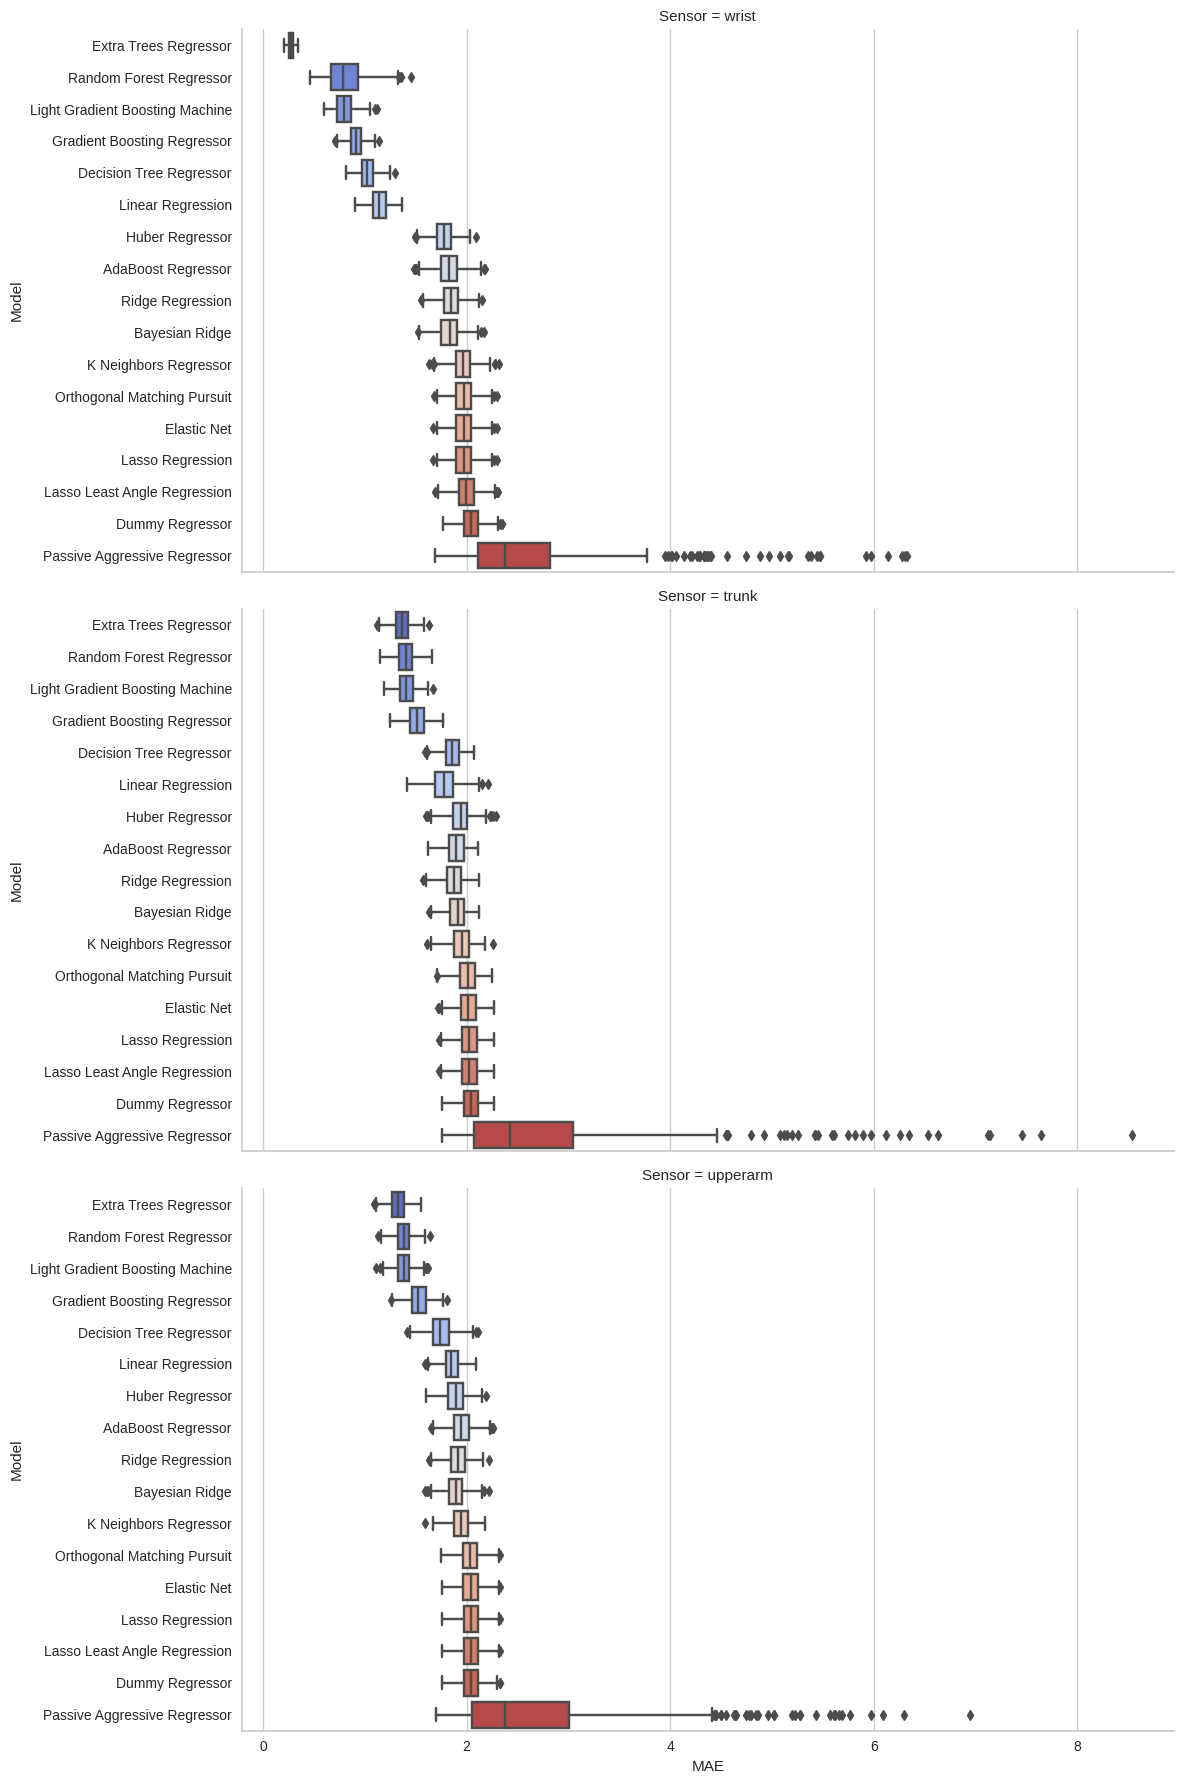

In [12]:
g = sns.FacetGrid(df_t_g_s, row='Sensor')
g.map(sns.boxplot, 'MAE', 'Model', palette='coolwarm')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

## Scatter Plot

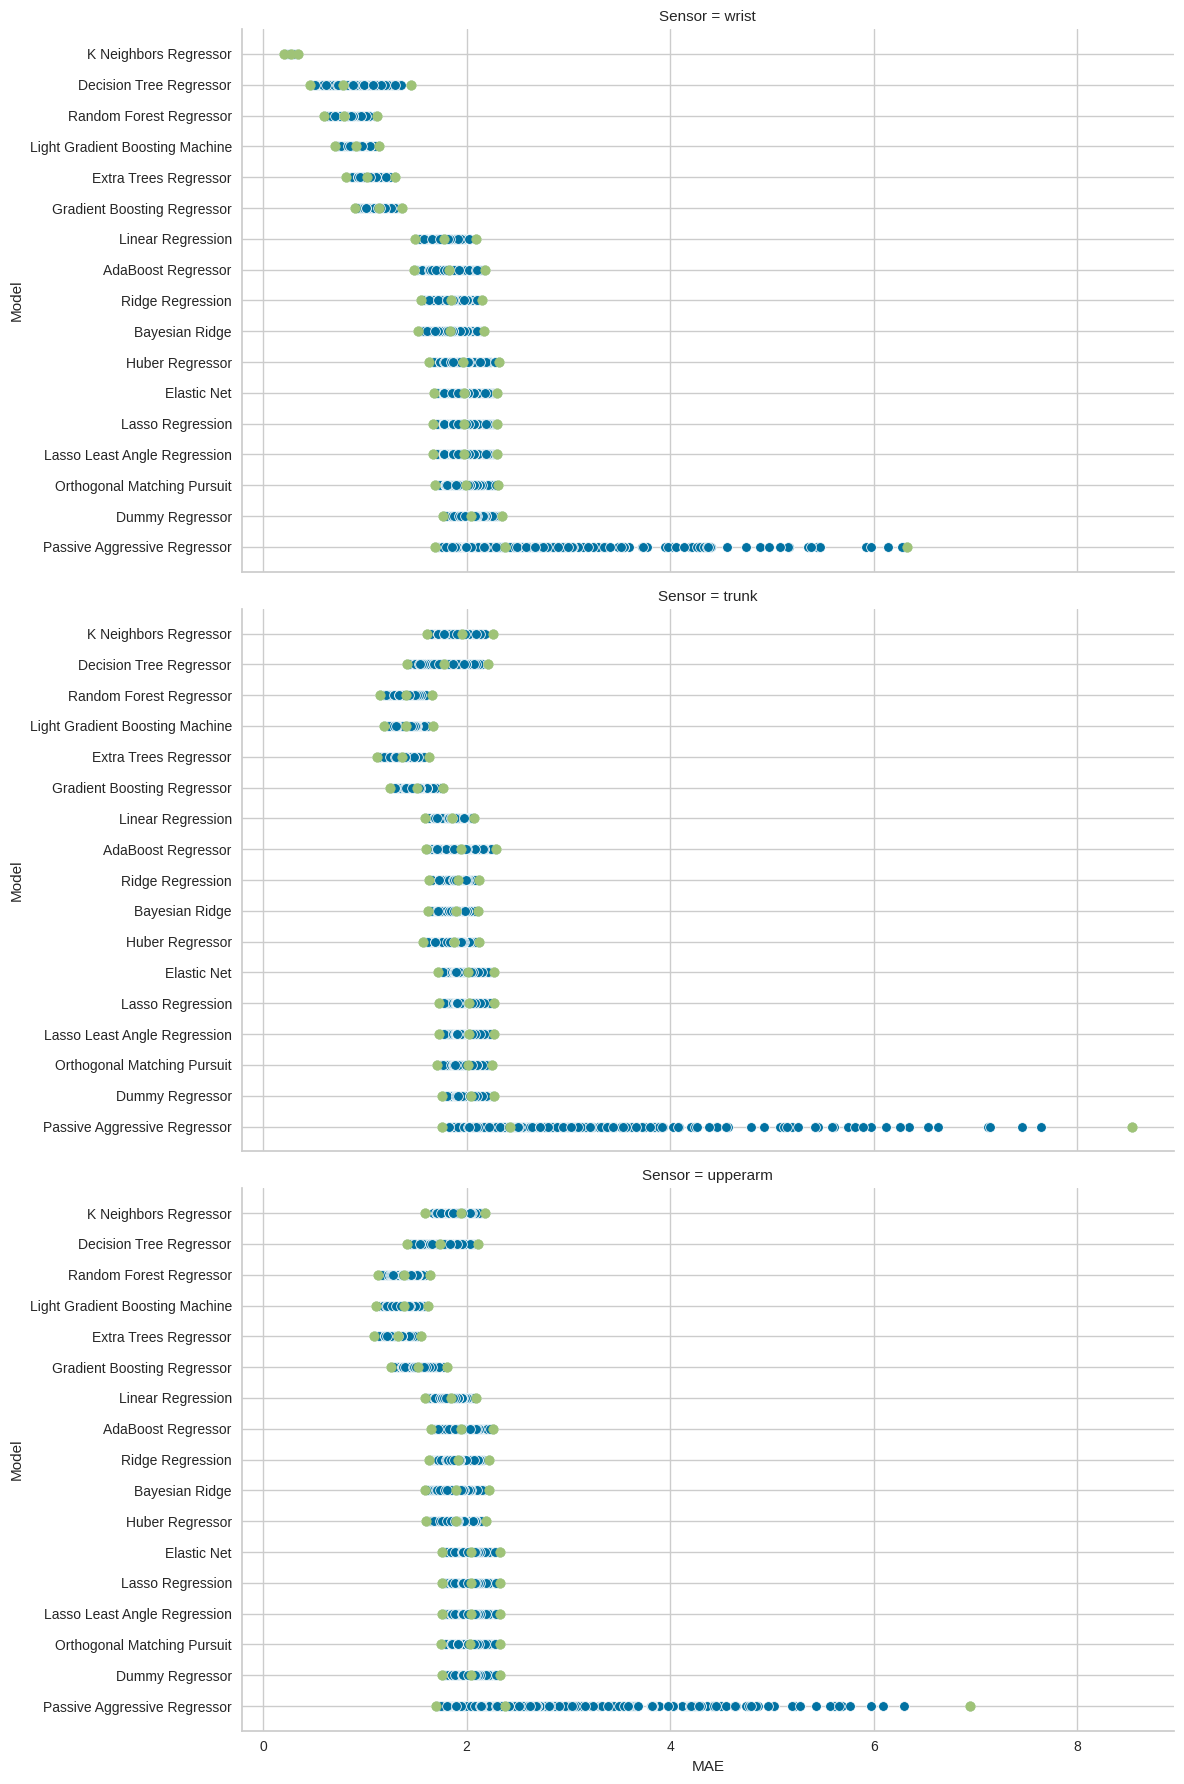

In [13]:
g = sns.FacetGrid(df_t_g_s, row='Sensor')
g.map(sns.scatterplot, 'MAE', 'Model', palette='coolwarm')

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Iterate through graphs and add quantiles
for ax, sensor in zip(g.axes.flat, g.row_names):
    # Filter the quantiles for the corresponding sensor
    quantiles = df_t_g_s[df_t_g_s['Sensor'] == sensor].groupby('Model')['MAE'].quantile(quantile_set).reset_index()
    # Plot the quantiles as points on the scatterplot
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='o')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='o')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='o')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

## Violin Plot

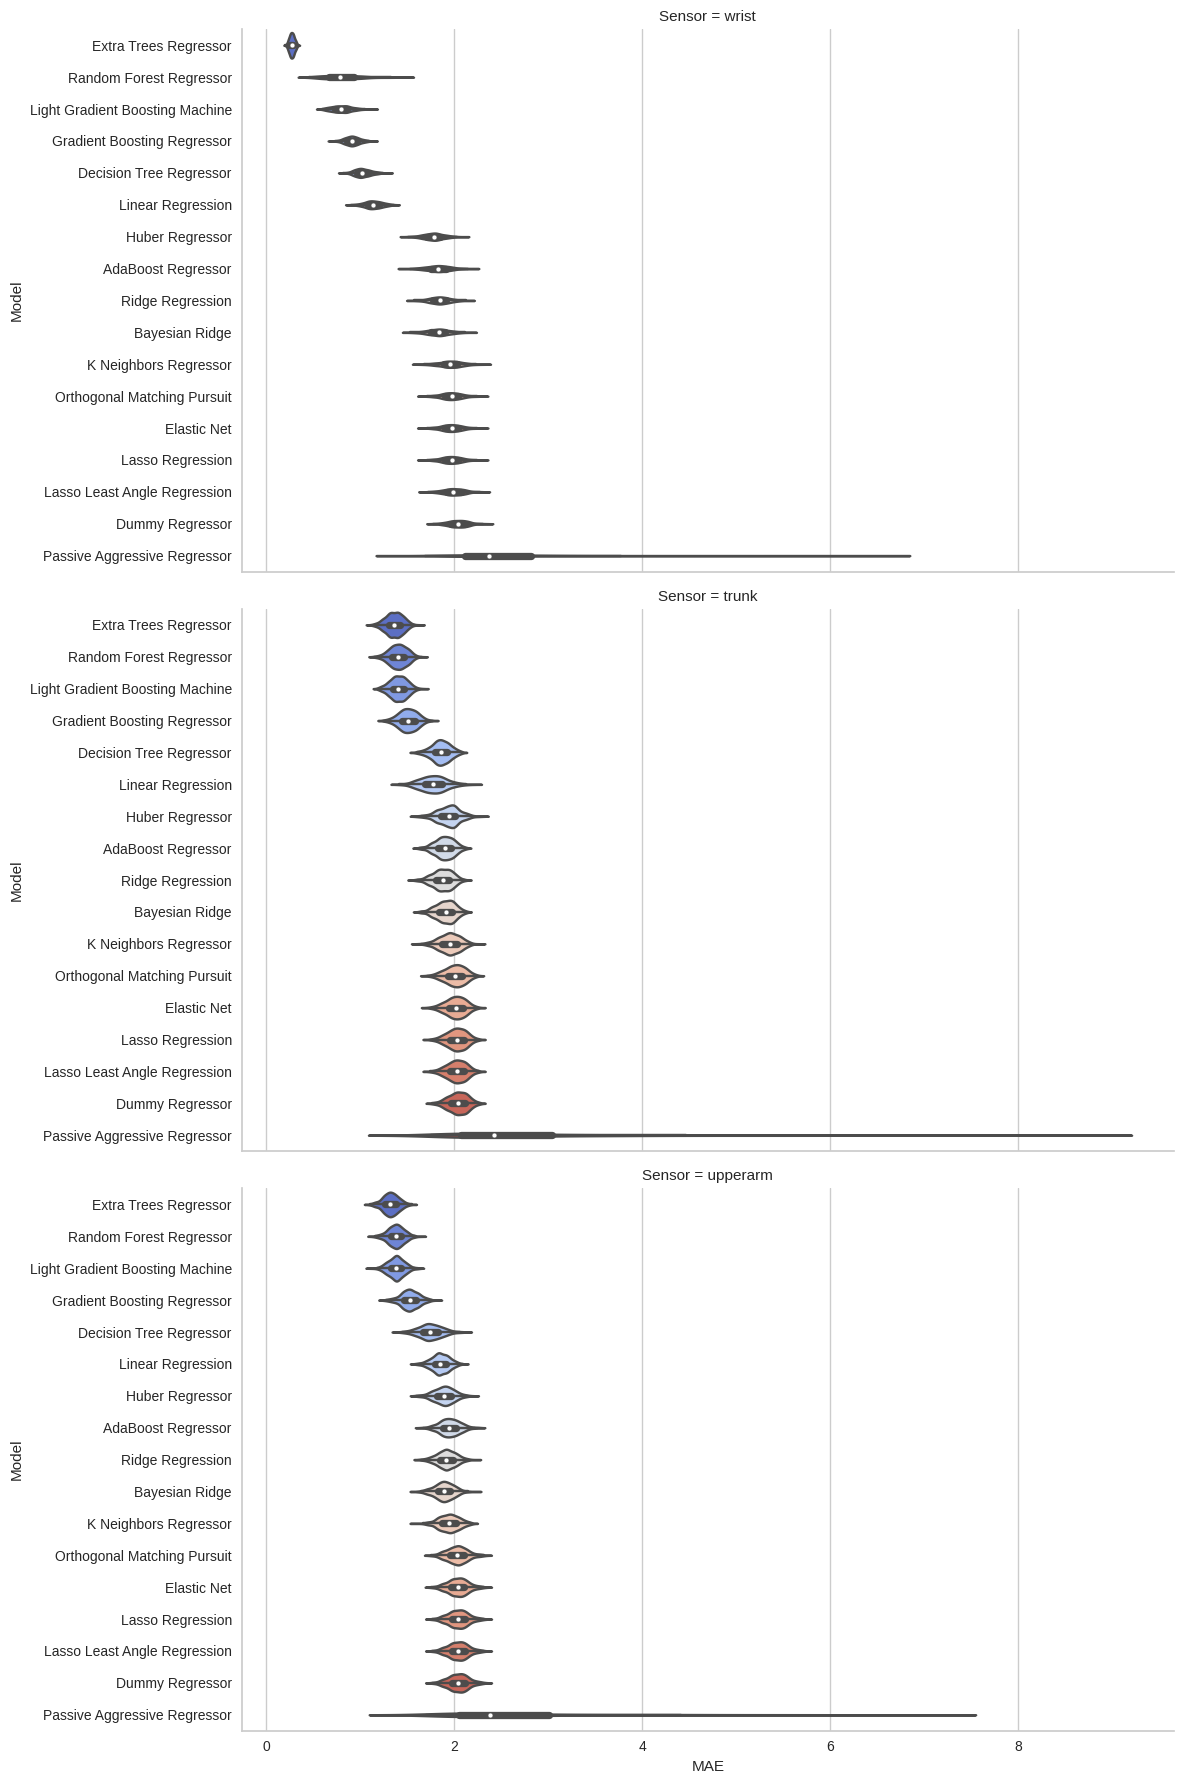

In [14]:
g = sns.FacetGrid(df_t_g_s, row='Sensor')
g.map(sns.violinplot, 'MAE', 'Model', palette='coolwarm', split=True)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

# Graphs (All), Individual

## Box Plot

<Axes: xlabel='MAE', ylabel='Model'>

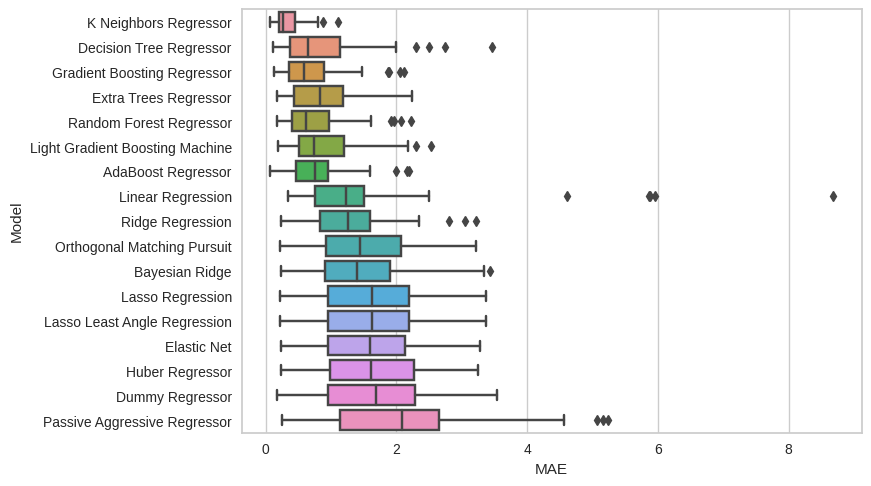

In [15]:
sns.boxplot(x='MAE', y='Model', data=df_t_i)

## Scatter Plot

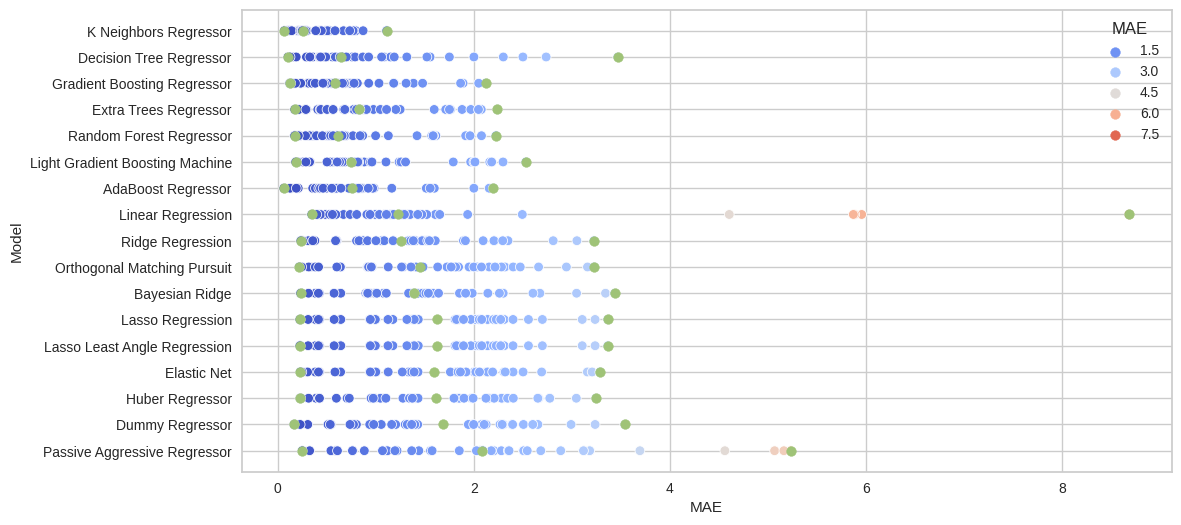

In [16]:
g = sns.scatterplot(data=df_t_i, x='MAE', y='Model', hue='MAE', palette='coolwarm')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 6)

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Filter the quantiles for each sensor
quantiles = df_t_i.groupby('Model')['MAE'].quantile(quantile_set).reset_index()

# Plot the quantiles as points on the scatterplot
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='o')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='o')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='o')

## Violin Plot

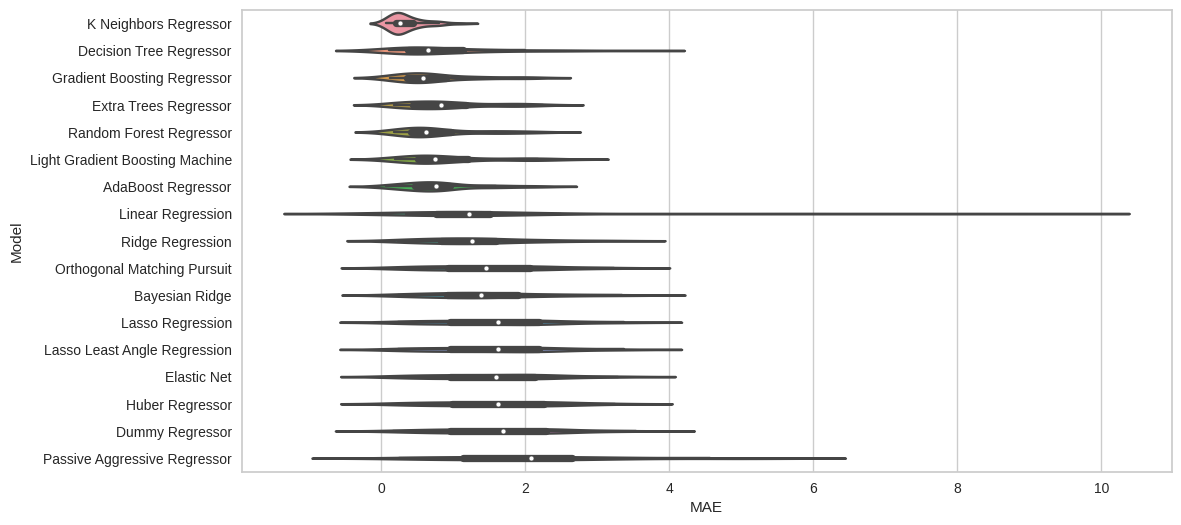

In [17]:
fig, ax = plt.subplots()
g = sns.violinplot(x='MAE', y='Model', data=df_t_i, ax=ax, pallete='coolwarm', split=True)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 6)

# Graphs (Sensor), Individual

In [18]:
df_t_i_s = get_data('outputs/individual/sensor_test_individual')
df_t_i_s = df_t_i_s[df_t_i_s['Model'] != 'Least Angle Regression']

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Subject,Sensor
0,K Neighbors Regressor,0.1176,0.0518,0.2275,0.9416,0.1278,0.1116,1,wrist
1,Decision Tree Regressor,0.2206,0.2500,0.5000,0.7180,0.3017,0.1939,1,wrist
2,Gradient Boosting Regressor,0.2590,0.1743,0.4175,0.8034,0.2416,0.2094,1,wrist
3,Random Forest Regressor,0.2653,0.1944,0.4410,0.7806,0.2578,0.2133,1,wrist
4,Extra Trees Regressor,0.3054,0.1901,0.4360,0.7855,0.2565,0.2326,1,wrist


## Box Plot

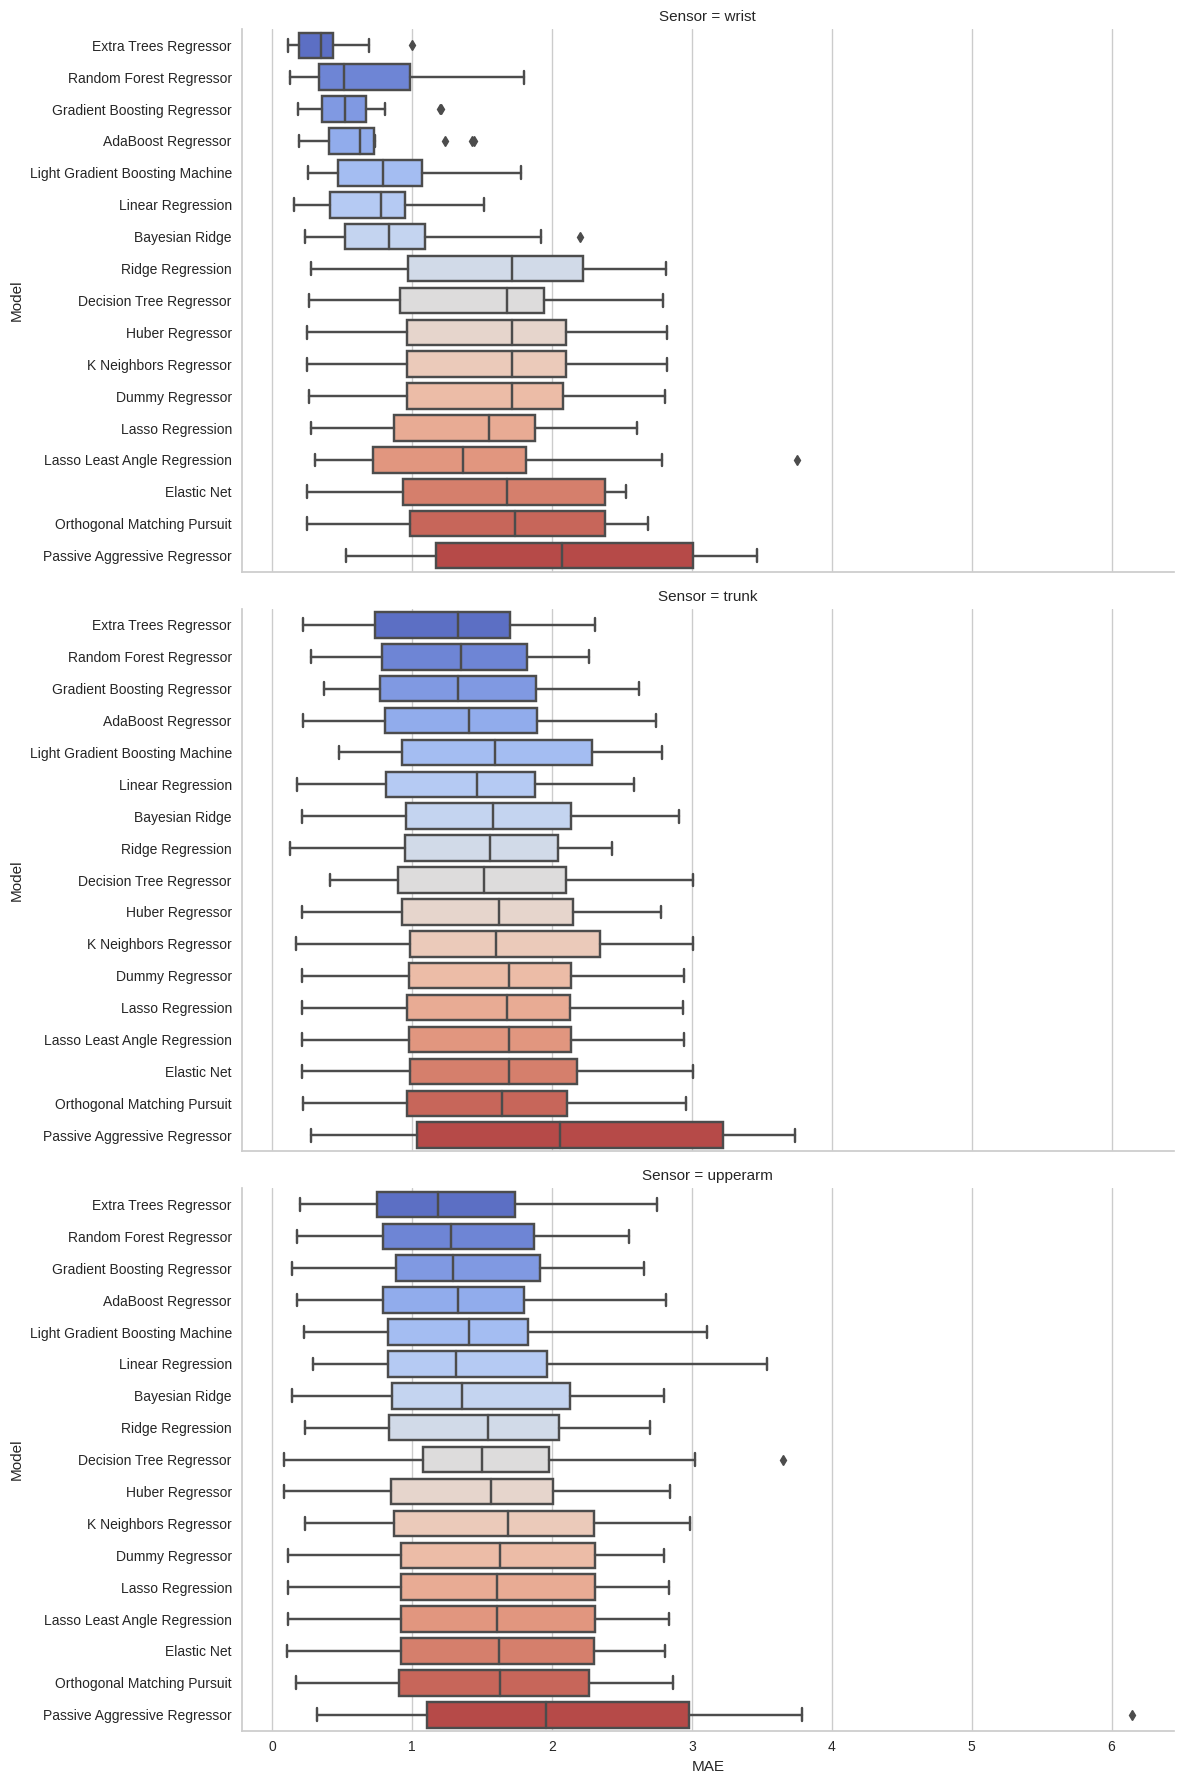

In [19]:
g = sns.FacetGrid(df_t_i_s, row='Sensor')
g.map(sns.boxplot, 'MAE', 'Model', palette='coolwarm')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

## Scatter Plot

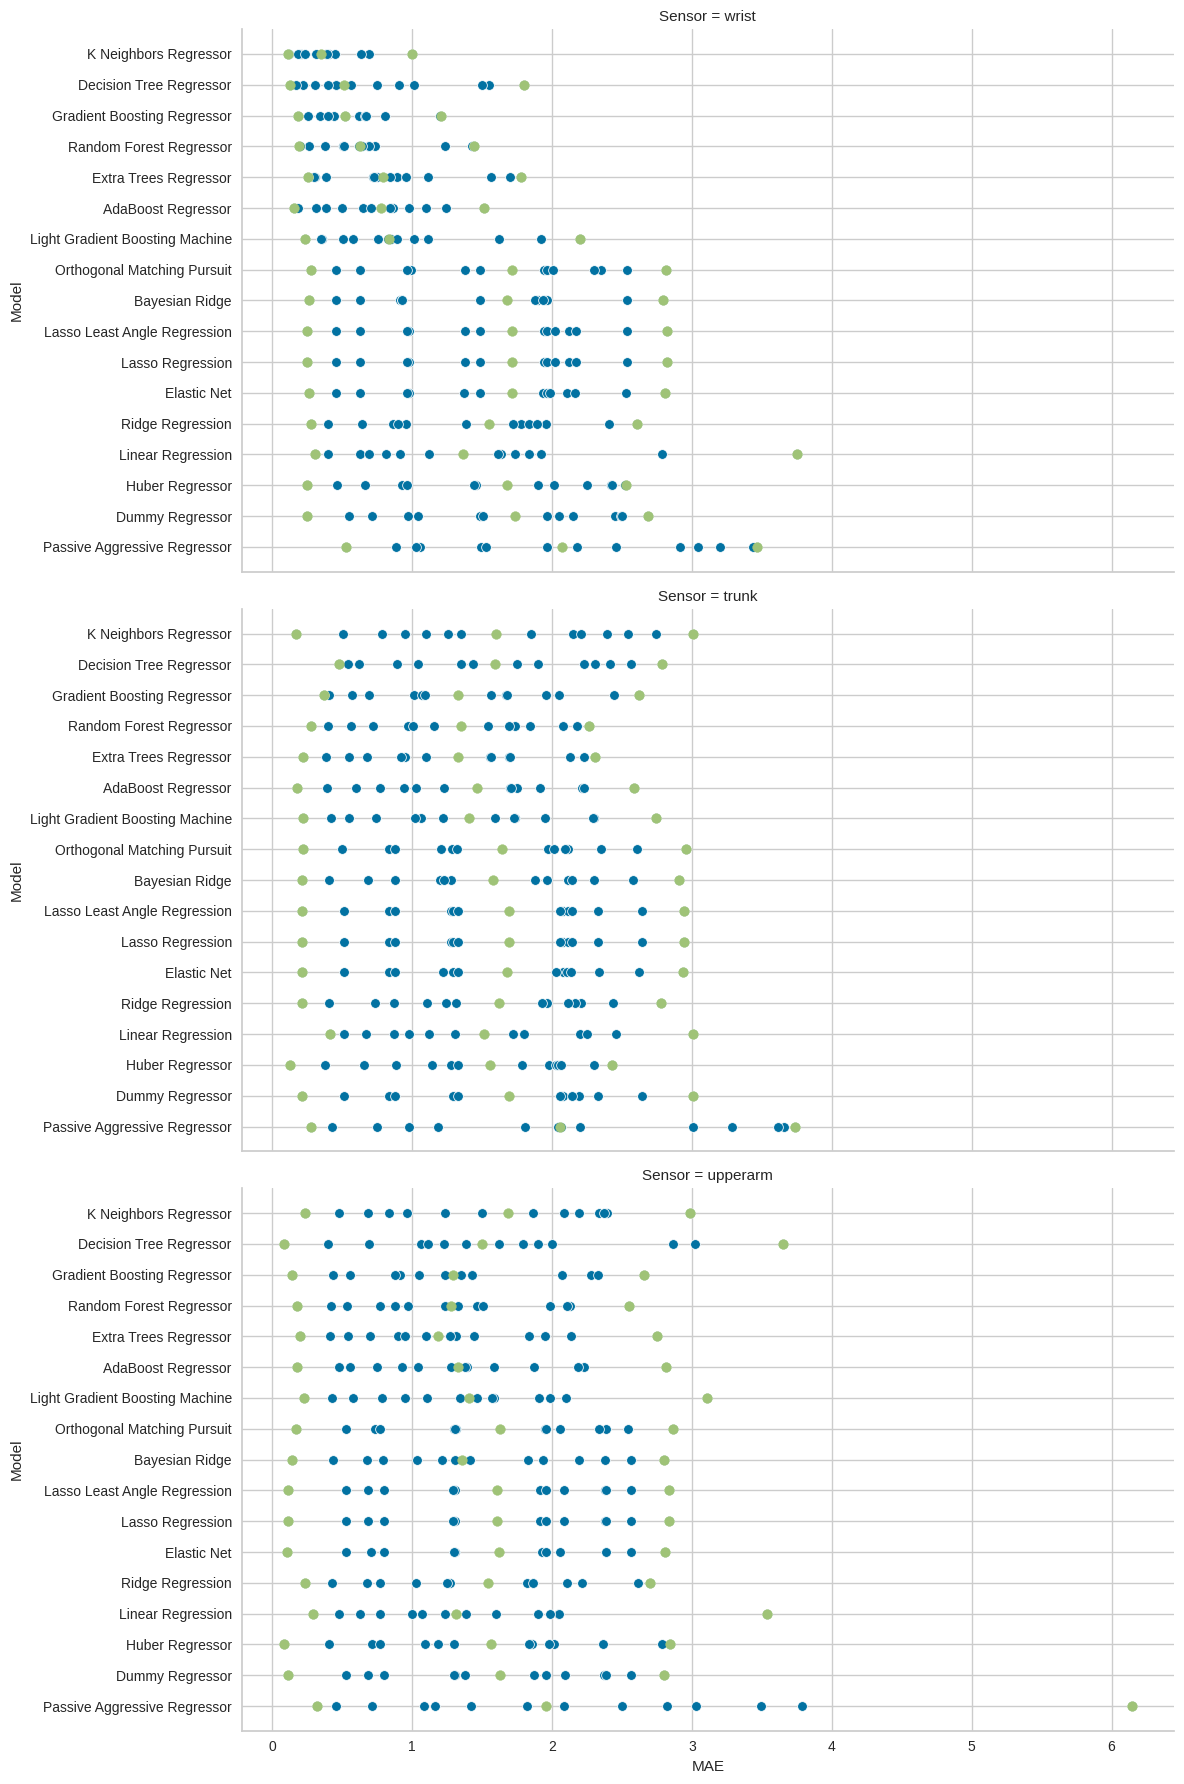

In [20]:
g = sns.FacetGrid(df_t_i_s, row='Sensor')
g.map(sns.scatterplot, 'MAE', 'Model', palette='coolwarm')

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Iterate through graphs and add quantiles
for ax, sensor in zip(g.axes.flat, g.row_names):
    # Filter the quantiles for the corresponding sensor
    quantiles = df_t_i_s[df_t_i_s['Sensor'] == sensor].groupby('Model')['MAE'].quantile(quantile_set).reset_index()
    # Plot the quantiles as points on the scatterplot
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='o')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='o')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='o')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

## Violin Plot

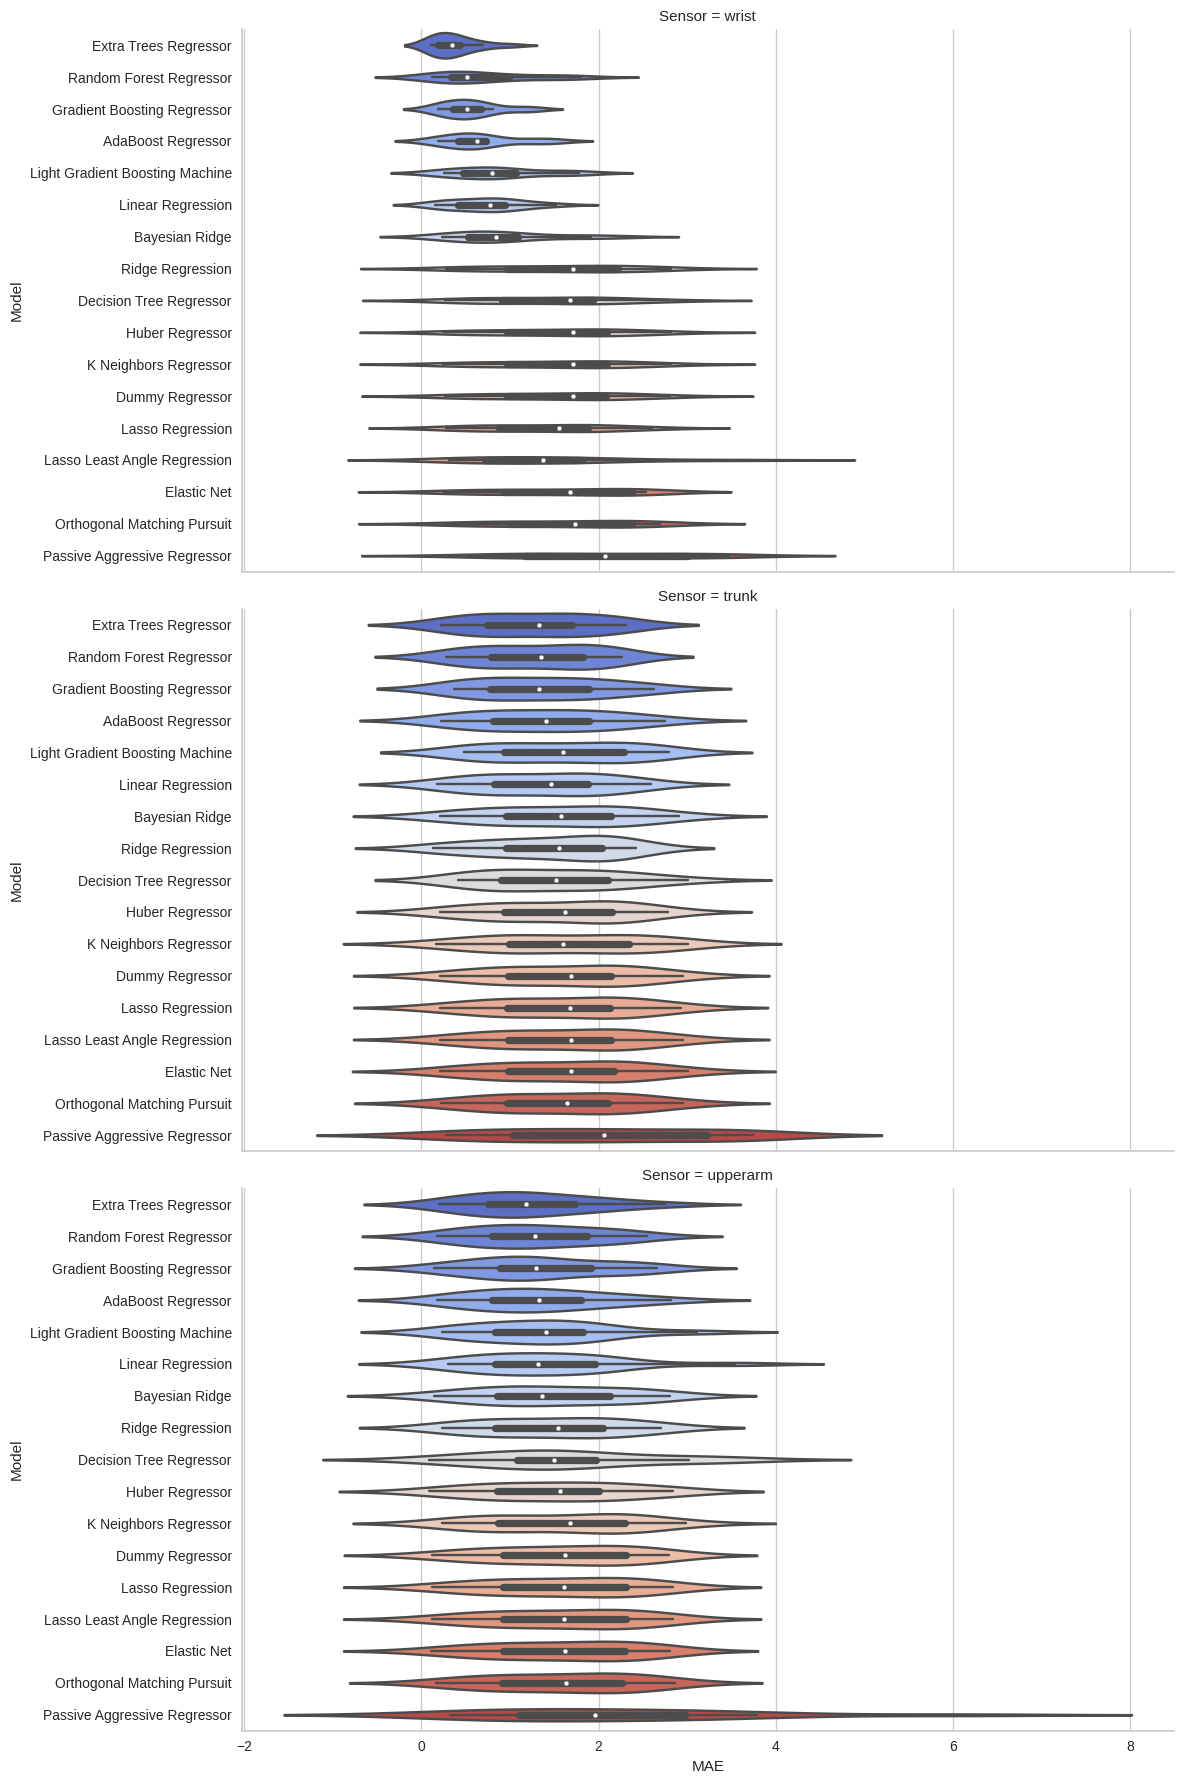

In [21]:
g = sns.FacetGrid(df_t_i_s, row='Sensor')
g.map(sns.violinplot, 'MAE', 'Model', palette='coolwarm', split=True)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

## Summary of General Table

- Rows: 1 per subject
- Columns: best model (mean/median), min max & avg MAE of subject, other participants with subject in best model

In [26]:
# Gets the list of unique subjects
subjects = set()
for t in df_t_g['Training Subjects'].unique():
    for s in ast.literal_eval(t):
        subjects.add(s)
list(subjects)

# Create the dataframe, allocate row for each subject
df_summary_general = DataFrame(columns=['Best Model', 'Min MAE', 'Max MAE', 'AVG MAE', 'Other Participants'])
for s in subjects:
    df_summary_general.loc[s] = {'Best Model': 'N/A', 'Min MAE': -1, 'Max MAE': -1, 'AVG MAE': -1, 'Other Participants': 'N/A'}

# Dict for avg MAE of subjects
avg_mae = dict.fromkeys(subjects, 0)

# Iterate through rows of df
for index, row in df_t_g.iterrows():
    # Iterate through subjects
    for s in subjects:
        if s in ast.literal_eval(row['Training Subjects']):
            # Build on AVG MAE
            avg_mae[s] += row['MAE']
            
            # Check if min MAE value/max MAE/best model/other participants can be updated
            if df_summary_general.loc[s, 'Min MAE'] == -1 or row['MAE'] < df_summary_general.loc[s, 'Min MAE']:
                other_participants = tuple(item for item in ast.literal_eval(row['Training Subjects']) if item != s)
                
                df_summary_general.loc[s, 'Best Model'] = row['Model']
                df_summary_general.loc[s, 'Min MAE'] = row['MAE']
                df_summary_general.loc[s, 'Other Participants'] = str(other_participants)
            elif df_summary_general.loc[s, 'Max MAE'] == -1 or row['MAE'] > df_summary_general.loc[s, 'Max MAE']:
                df_summary_general.loc[s, 'Max MAE'] = row['MAE']

# Averages calculated, added to dataframe
avg_mae = {key: value / 1403 for key, value in avg_mae.items()}
for s in avg_mae.keys():
    df_summary_general.loc[s, 'AVG MAE'] = avg_mae[s]

# Dataframe set to CSV
df_summary_general.to_csv('outputs/summary/summary_general.csv', mode='w', header=True, index=True)

In [27]:
df_summary_general

,Best Model,Min MAE,Max MAE,AVG MAE,Other Participants
1,K Neighbors Regressor,0.2401,5.7093,1.525079,"(13, 15)"
2,K Neighbors Regressor,0.2161,5.2297,1.467417,"(3, 13)"
3,K Neighbors Regressor,0.2101,5.5881,1.396430,"(12, 13)"
4,K Neighbors Regressor,0.2247,6.1254,1.513869,"(13, 16)"
5,K Neighbors Regressor,0.2441,6.1179,1.525473,"(3, 9)"
6,K Neighbors Regressor,0.2152,5.3246,1.434325,"(3, 13)"
8,K Neighbors Regressor,0.2267,6.2272,1.503851,"(13, 16)"
9,K Neighbors Regressor,0.2271,6.1179,1.446188,"(13, 16)"
10,K Neighbors Regressor,0.2183,5.9302,1.524657,"(6, 13)"
12,K Neighbors Regressor,0.2101,6.2272,1.508363,"(3, 13)"


## Summary of Individual Table

- Rows: 1 per subject
- Columns: best model (mean/median), min max & avg MAE of subject

In [24]:
# SAME PROCESS AS IN GENERAL TABLE

# Create the dataframe
df_summary_individual = DataFrame(columns=['Best Model', 'Min MAE', 'Max MAE', 'AVG MAE'])
for s in subjects:
    df_summary_individual.loc[s] = {'Best Model': 'N/A', 'Min MAE': -1, 'Max MAE': -1, 'AVG MAE': -1}

# Dict for avg MAE of subjects
avg_mae = dict.fromkeys(subjects, 0)
for index, row in df_t_i.iterrows():
    for s in subjects:
        if row['Subject'] == s:
            # Build on AVG MAE
            avg_mae[s] += row['MAE']
            
            if df_summary_individual.loc[s, 'Min MAE'] == -1 or row['MAE'] < df_summary_individual.loc[s, 'Min MAE']:
                df_summary_individual.loc[s, 'Best Model'] = row['Model']
                df_summary_individual.loc[s, 'Min MAE'] = row['MAE']
            elif df_summary_individual.loc[s, 'Max MAE'] == -1 or row['MAE'] > df_summary_individual.loc[s, 'Max MAE']:
                df_summary_individual.loc[s, 'Max MAE'] = row['MAE']

avg_mae = {key: value / 17 for key, value in avg_mae.items()}
for s in avg_mae.keys():
    df_summary_individual.loc[s, 'AVG MAE'] = avg_mae[s]


df_summary_individual.to_csv('outputs/summary/summary_individual.csv', mode='w', header=True, index=True)

In [25]:
df_summary_individual

,Best Model,Min MAE,Max MAE,AVG MAE
1,K Neighbors Regressor,0.0941,0.8824,1.466688
2,K Neighbors Regressor,0.2507,2.1771,3.892218
3,K Neighbors Regressor,0.3917,5.2291,5.007129
4,K Neighbors Regressor,0.1378,3.1229,2.455641
5,K Neighbors Regressor,0.0667,0.6084,1.001224
6,K Neighbors Regressor,0.6700,8.6839,8.306076
8,AdaBoost Regressor,0.0612,1.6514,0.923994
9,K Neighbors Regressor,0.2088,3.1823,4.333435
10,K Neighbors Regressor,0.2317,2.0907,2.416912
12,K Neighbors Regressor,0.2436,1.8510,3.114159
